In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import xarray as xr
sys.path.insert(0, os.path.abspath('../src'))
from ray_vapor import RayVapor
###################################
import scipy as sp
from scipy.optimize import minimize
import time

In [2]:
rv_data = xr.open_mfdataset('input/qvapor_slice.nc', combine='by_coords')
y=108
num_or=50
nz = len(rv_data.bottom_top) - 1 #* 0.8
rv = RayVapor(rv_data, num_obs=num_or, z=nz)

In [3]:
rv.set_num_rays(num_or)
rv.num_rays
rv.compute_obs()

- first compute, angles being saved for future computation


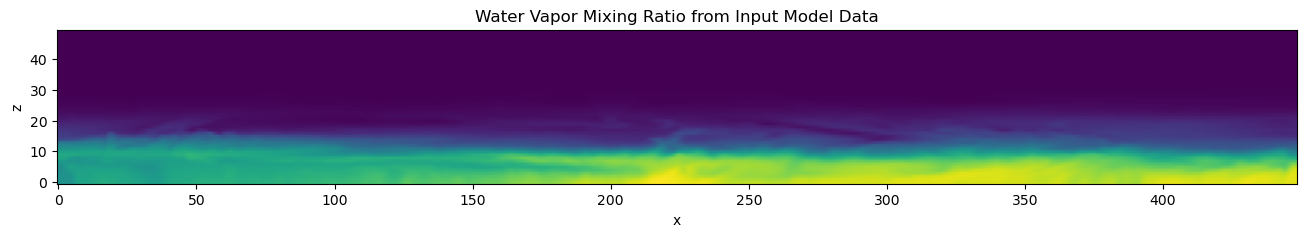

In [4]:
rv.plot_env()

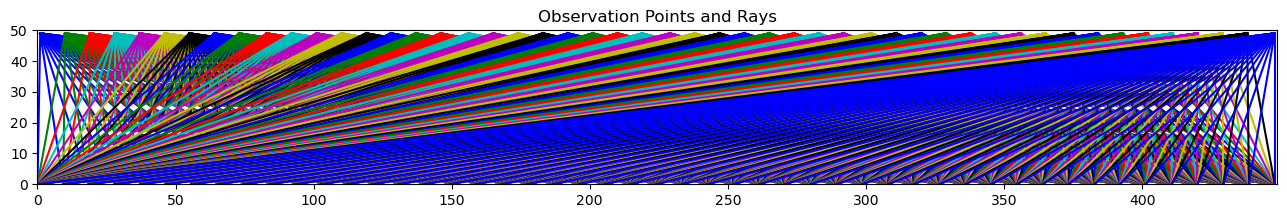

In [5]:
### resetting after initialization is broken right now
#rv.set_num_obs(40)
#rv.set_num_rays(40)
### Plot observation rays from observation points. 
rv.plot_obs_rays(obs_mod=1,ray_mod=1)
### Plotting the observations is a dot plot of the values collled, warning: slow to visualize
#rv.plot_obs(z_mod=4)

In [5]:
#help(RayVapor)

In [ ]:
#######################################################################
#######################################################################
###                     Reconstruction                              ###
#######################################################################
#######################################################################

In [8]:
global mod
mod=10
global num_iterations
q_nx = round((rv.get_target_end()-rv.get_target_start()) / mod)
q_nx = round(rv.nx / mod)
q_nz = round(rv.nz / mod)
num_obs = rv.num_obs
y=108 # from prep file of qvapor slice

def callback(xk):
    global num_iterations
    num_iterations += 1
    
# Initialize the number of iterations counter
def objective(qv_guess):
    global num_iterations
    qv_guess = qv_guess.reshape(q_nz,1,q_nx).repeat(mod,axis=0).repeat(mod,axis=2) #.repeat(2,axis=1).shape

    rv_guess = RayVapor(qv_guess, num_obs, nz)
    rv_guess.copy_rv_setup(rv)
    rv_guess.compute_obs() # double check the updated observation is being used here
    err = np.mean((rv.qvapor_mean_integration - rv_guess.qvapor_mean_integration)**2)
    
    if num_iterations%500 == 0:
        print(num_iterations, ": err", err)
    num_iterations += 1
    return err


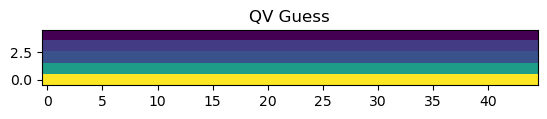

In [9]:
global num_iterations
qv_max = 0.04

# --- new qv_guess creation method
qv_guess = np.random.random((q_nz, q_nx))* (qv_max/(q_nz*3))
qv_guess = np.flip(np.cumsum(qv_guess, axis=0), axis=0)
# --- gv_guess, every row is the same at the one in the first column
qv_guess = np.random.random((q_nz,1))* (qv_max/(q_nz*3))
qv_guess = np.flip(np.cumsum(qv_guess, axis=0), axis=0)
qv_guess = qv_guess.repeat(q_nx,axis=1)

# --- plot and flatten the guess
plt.imshow(qv_guess,origin='lower')
plt.title('QV Guess')
plt.show()
qv_guess = qv_guess.flatten()

saved_qv_guess = qv_guess
#plt.imshow(qv_guess,origin='lower')

bounds = [(0, qv_max)]# * q_nx * q_nz
solutions = np.zeros((rv.num_obs, q_nx * q_nz))
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# subset of methods that worked best during initial testing
methods = ['Nelder-Mead','Powell']

--- coarse environment ---


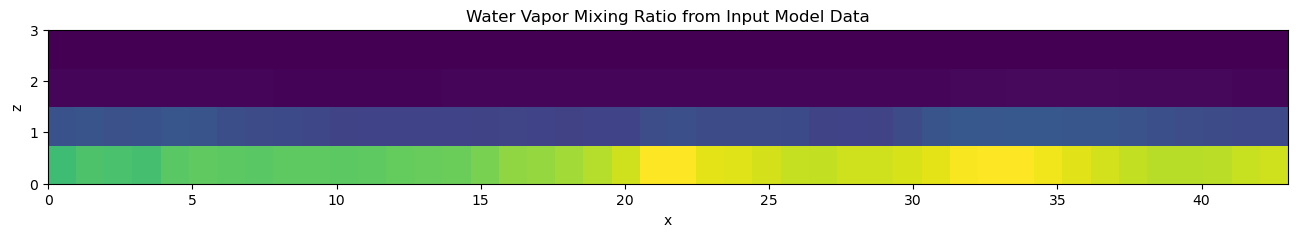

mod =  10
---------
starting Nelder-Mead
0 : err 0.0002462930289224587
: successful method Nelder-Mead took 40.08 sec and 227 iterations


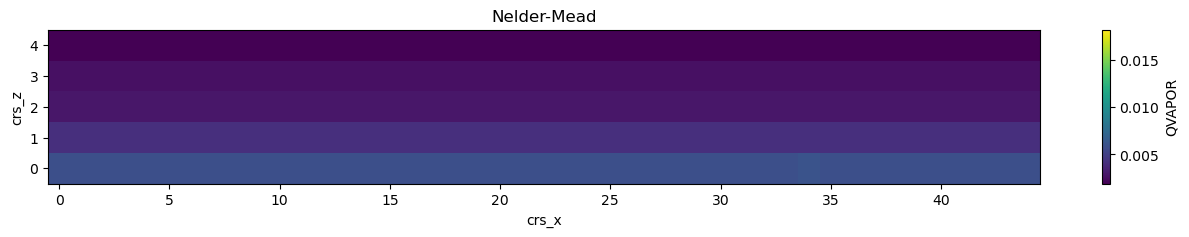

saving to rv_Nelder-Mead_10mod_0.01tol_226iter.nc
starting Powell
0 : err 0.0002462930289224587
500 : err 0.003194776888878078
: successful method Powell took 157.44 sec and 902 iterations


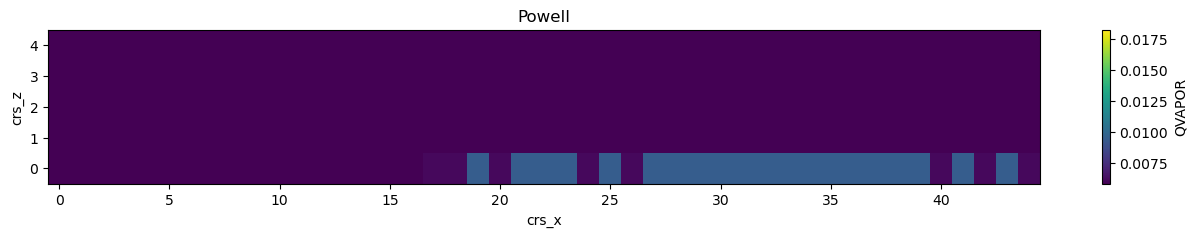

saving to rv_Powell_10mod_0.01tol_901iter.nc


In [10]:
# with bounds: 20 obs, lower tolerance, 0.001 didn't finish in the previous run
# with mod=10
print('--- coarse environment ---')
rv.plot_env(mod=mod)
print('mod = ', str(mod))
print('---------')
qv_max = rv.qvapor.max()
tol = 0.01
num_iterations = 200


for m in methods:
    print('starting', m)
    num_iterations = 0
    max_iter = 200
    try:
        start_t = time.time()
        #result = minimize(objective, saved_qv_guess, method=m, tol=tol, options={'maxiter':max_iter}, callback=callback)
        result = minimize(objective, saved_qv_guess, bounds=bounds, method=m, tol=tol, options={'maxiter':max_iter}, callback=callback)
        end_t = time.time()
        total_t = end_t - start_t
    except Exception as error:
        print('failed method:', m,'raised exception', error)
    else:
        if result['success'] == True:
            solutions = result['x']
            qv_guess = result['x']
            print(': successful method '+str(m)+' took {:.2f} sec'.format(total_t)+' and '+str(num_iterations)+' iterations')
            
            rv.set_solution(result, m, tol, mod, q_nx, q_nz, total_t, env_south_north=y)
            rv.plot_solution(qv_max=qv_max)
            rv.save_solution()
        else:
            print('failed method:', m)